In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
df_taxi = pd.read_csv('taxi.csv', parse_dates=True, index_col=['datetime'])
df_taxi.sort_index(inplace=True)
df_taxi = df_taxi.resample('1H').sum()

display(df_taxi.head(10))
df_taxi.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [4]:
def plotRollingMean(data, size):
    rolling_mean = data.rolling(size).mean()

    plt.figure(figsize=(15,5))
    plt.plot(data[size:], label="Original Values", alpha=0.6)
    plt.plot(rolling_mean, 'r', label="Rolling Mean")             
    plt.legend(loc="upper left")

    plt.xlabel('Date')
    plt.ylabel('Number of Orders')
    plt.title('Original Data w/ Rolling Mean\n Size: {}'.format(size))

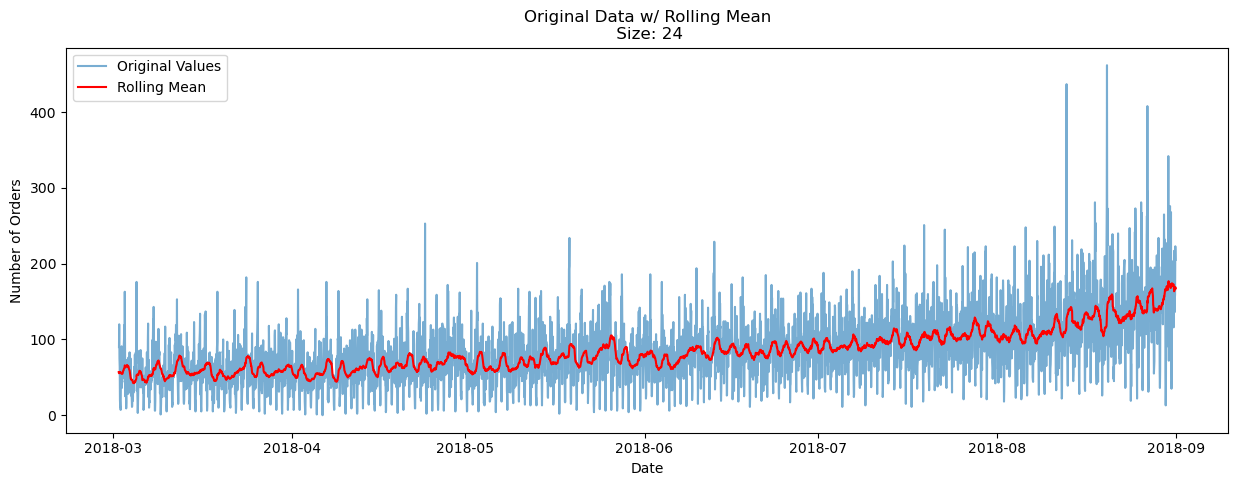

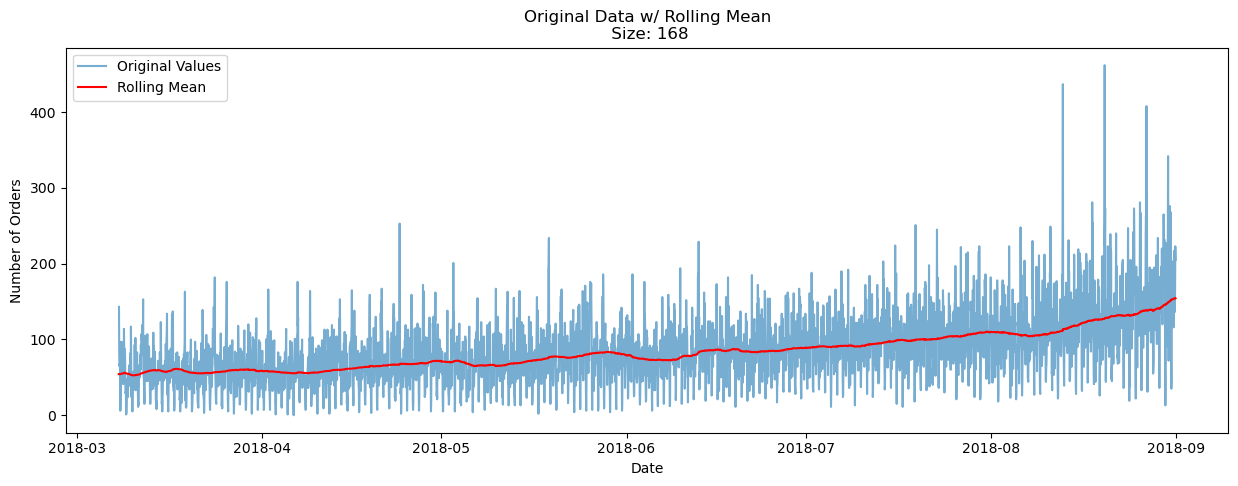

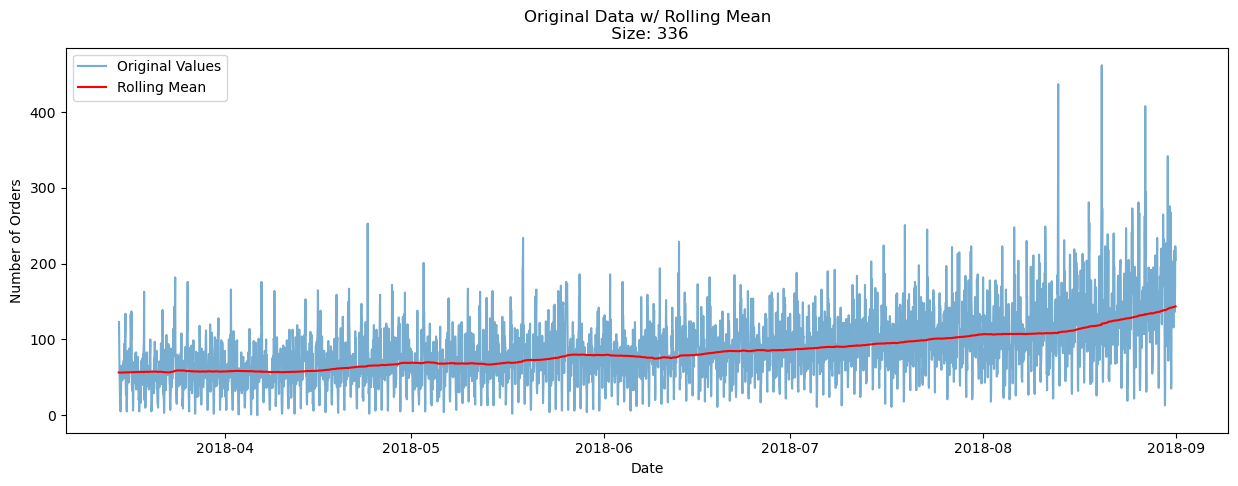

In [5]:
plotRollingMean(df_taxi, 24) # 24 hours
plotRollingMean(df_taxi, 168) # 168 hours = 1 week
plotRollingMean(df_taxi, 336) # 336 hours = 2 weeks

Text(0.5, 1.0, 'Seasonal Decomposition: August')

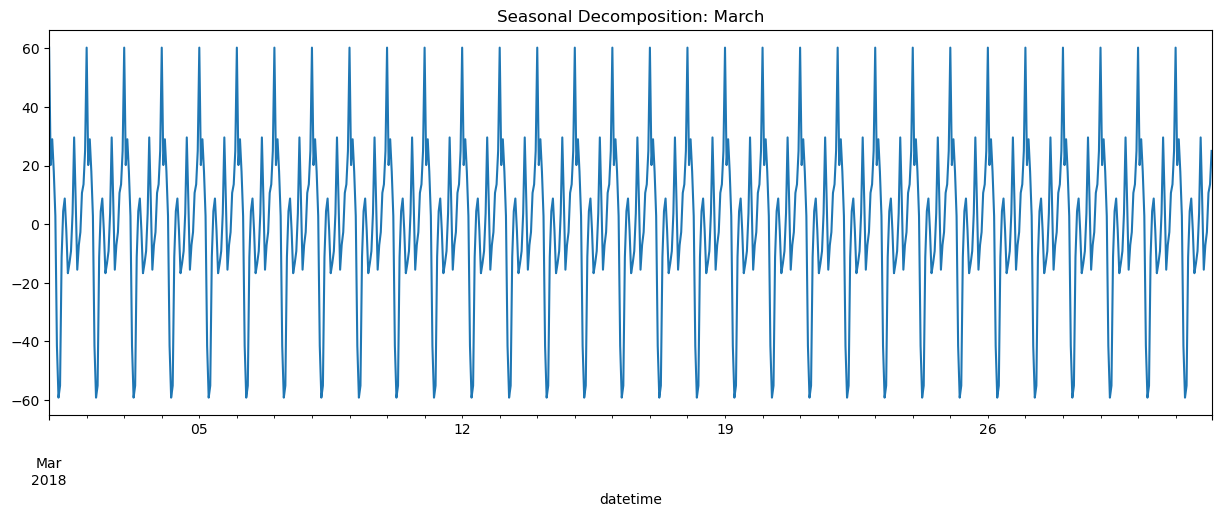

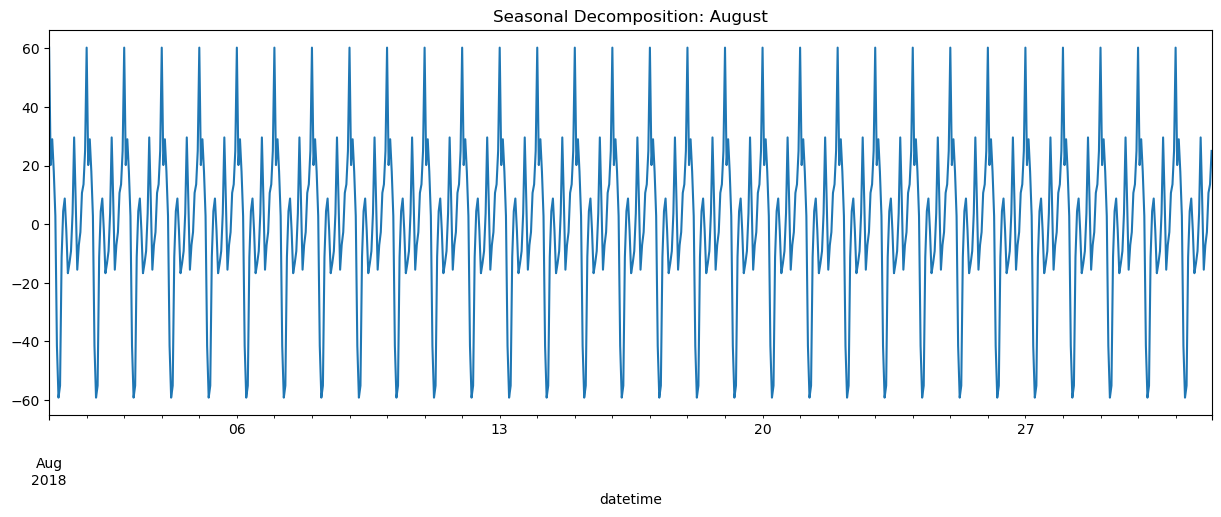

In [6]:
decomposed = seasonal_decompose(df_taxi)
plt.figure(figsize=(15, 5))
decomposed.seasonal['2018-03-01':'2018-03-31'].plot()
plt.title ('Seasonal Decomposition: March')

plt.figure(figsize=(15, 5))
decomposed.seasonal['2018-08-01':].plot()
plt.title ('Seasonal Decomposition: August')

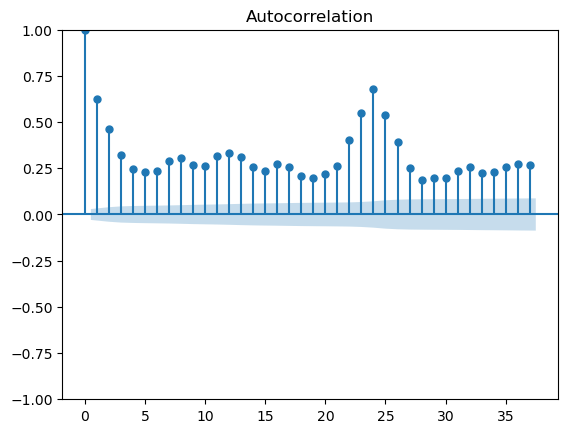

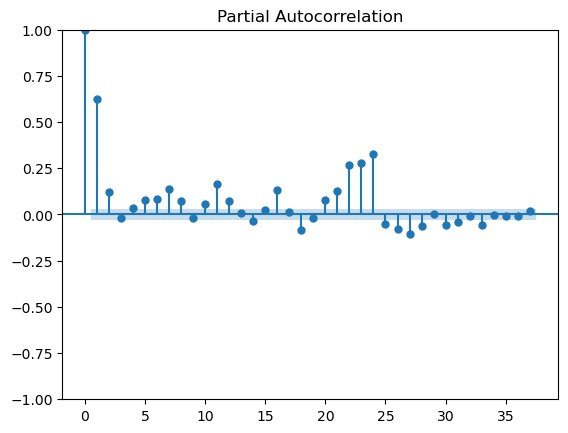

In [7]:
ax = plot_acf(df_taxi)
plt.show()

ax = plot_pacf(df_taxi, method='ywm')
plt.show()

In [8]:
df_taxi['dayofweek'] = df_taxi.index.dayofweek
df_taxi['day'] = df_taxi.index.day
df_taxi['month'] = df_taxi.index.month

In [9]:
for lag in range(1, 25):
    df_taxi['lag_{}'.format(lag)] = df_taxi['num_orders'].shift(lag)
    

In [10]:
df_taxi['rolling_mean'] = df_taxi['num_orders'].shift().rolling(168).mean()


In [11]:
df_taxi.dropna(inplace=True)
display(df_taxi.head(10))

,num_orders,dayofweek,day,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,3,8,3,94.0,127.0,108.0,76.0,50.0,99.0,...,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,100.0,54.226190
2018-03-08 01:00:00,78,3,8,3,143.0,94.0,127.0,108.0,76.0,50.0,...,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,54.339286
2018-03-08 02:00:00,65,3,8,3,78.0,143.0,94.0,127.0,108.0,76.0,...,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,54.297619
2018-03-08 03:00:00,68,3,8,3,65.0,78.0,143.0,94.0,127.0,108.0,...,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,54.261905
2018-03-08 04:00:00,60,3,8,3,68.0,65.0,78.0,143.0,94.0,127.0,...,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,54.273810
2018-03-08 05:00:00,6,3,8,3,60.0,68.0,65.0,78.0,143.0,94.0,...,55.0,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,54.375000
2018-03-08 06:00:00,6,3,8,3,6.0,60.0,68.0,65.0,78.0,143.0,...,43.0,55.0,34.0,58.0,34.0,50.0,38.0,17.0,19.0,54.375000
2018-03-08 07:00:00,19,3,8,3,6.0,6.0,60.0,68.0,65.0,78.0,...,51.0,43.0,55.0,34.0,58.0,34.0,50.0,38.0,17.0,54.339286
2018-03-08 08:00:00,77,3,8,3,19.0,6.0,6.0,60.0,68.0,65.0,...,46.0,51.0,43.0,55.0,34.0,58.0,34.0,50.0,38.0,54.363095


In [16]:
def train_and_evaluate(model, train_valid_feat, train_valid_tgt, params={}):
    tscv = TimeSeriesSplit(n_splits=5)
    ct = ColumnTransformer([('scaler', MaxAbsScaler(), train_valid_feat.columns)])
    pipe = Pipeline([('col_transform' , ct), ('model', model)])
    
    grid_pipeline = GridSearchCV(pipe, param_grid=params, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=-1)
    grid_pipeline.fit(train_valid_feat, train_valid_tgt)
        
    print('Best score: ', grid_pipeline.best_score_)
    print('Best parameters: ', grid_pipeline.best_params_)
    return grid_pipeline.best_estimator_


In [17]:
train_valid, test = train_test_split(df_taxi, shuffle=False, test_size=0.10)
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.10)

# train/valid set for LR model
train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']
valid_features = valid.drop('num_orders', axis=1)
valid_target = valid['num_orders']

print(train_features.shape, train_target.shape)
print(valid_features.shape, valid_target.shape)

# combined train_valid set for GridSearchCV
train_valid_features = train_valid.drop('num_orders', axis=1)
train_valid_target = train_valid['num_orders']

print(train_valid_features.shape, train_valid_target.shape)

# final test set
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

print(test_features.shape, test_target.shape)

(3440, 28) (3440,)
(383, 28) (383,)
(3823, 28) (3823,)
(425, 28) (425,)


In [18]:
lr_model = LinearRegression()
lr_model.fit(train_features, train_target)

print('RMSE: ', mean_squared_error(valid_target, lr_model.predict(valid_features), squared=False))

RMSE:  35.14541873875118


In [19]:
dt_model = DecisionTreeRegressor(random_state=12345)
dt_model.fit(train_features, train_target)

print('Tree depth: ', dt_model.get_depth())
print('Default DT RMSE: ', mean_squared_error(valid_target, dt_model.predict(valid_features), squared=False))

Tree depth:  30
Default DT RMSE:  44.400709189170676


In [20]:
params_dt = {'model__max_depth': list(range(3,31)),
             'model__min_samples_split': [2, 4, 6],
             'model__min_samples_leaf': [0.1, 0.5, 1, 5, 10],
             'model__max_features': [None, 'sqrt', 'log2']}

grid_dt = train_and_evaluate(DecisionTreeRegressor(random_state=12345), train_valid_features, train_valid_target, params=params_dt)

Best score:  -29.615282444886144
Best parameters:  {'model__max_depth': 7, 'model__max_features': None, 'model__min_samples_leaf': 10, 'model__min_samples_split': 2}


In [23]:
rf_model = RandomForestRegressor(random_state=12345)
rf_model.fit(train_features, train_target)

est_list = []
for est in rf_model.estimators_:
    est_list.append(est.get_depth())

print('Shortest tree: ', min(est_list))
print('Tallest tree: ', max(est_list))
print('RMSE: ', mean_squared_error(valid_target, rf_model.predict(valid_features), squared=False))

Shortest tree:  22
Tallest tree:  36
RMSE:  33.013053787335934


In [ ]:
params_rf = {'model__n_estimators': [10, 25, 50, 75, 100],
             'model__max_depth': list(range(10, 36, 5)),
             'model__max_features': [None, 'sqrt', 'log2']}
             
grid_rf = train_and_evaluate(RandomForestRegressor(random_state=12345), train_valid_features, train_valid_target, params=params_rf)

In [ ]:
best_model = grid_rf
test_predict = best_model.predict(test_features)

print('Final RMSE: ', mean_squared_error(test_target, test_predict, squared=False))

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(test_features.index, test_predict)
plt.plot(test_features.index, test_target, color='red', alpha=0.5)
plt.legend(['Predicted Values','True Values'])
plt.show()